뉴련 스타일 트랜스퍼는 타깃 이미지의 콘텐츠를 보존하면서 참조 이미지의 스타일을 타깃 이밎에 적용한다. 

여기에서 스타일은 질감, 색깔, 이미지에 있는 다양한 크기의 시각 요소를 의마한다. 콘텐츠는 이미지에 있는 고수준의 대형 구조를 말한다. 예를 들어 그림 별이 빛나는 밤에서 파란색과 노란색의 원을 그리는 듯한 붓질을 하나의 스타일로 생각할 수 있다. 튀빙겐 사진의 건물은 콘텐츠로 생각할 수 있다.

![](https://jvns.ca/images/neural-style.png)

> https://jvns.ca/blog/2017/02/12/neural-style/

스타일 트랜스퍼 구현 이면에 있는 핵심 개념은 모든 딥러닝 알고리즘의 핵심과 동일하다. 목표를 표현한 손실 함수를 정의하고 이 손실을 최소화한다. 여기서 원하는 것은 다음과 같다.

참조 이미지의 스타일을 적용하면서 원본 이미지의 콘텐츠를 보전하는 것이다. 콘텐츠와 스타일을 수학적으로 정의할 수 있다면 최소화할 손실 함수는 다음과 같을 것이다.

```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))

```

여기서 distance는 L2 노름 같은 노름 함수이다. content 함수는 이미지의 콘텐츠 표현을 계산한다. style 함수는 이미지의 스타일 표현을 계산한다. 이 손실을 최소화하면 style(generated_imge)는 style(refernce_image)와 가까워지고, content(generated_imge)는 content(original_image)와 가까워진다. 앞서 정의한 스타일 트랜스퍼의 목적을 달성할 수 있다.

케라스 등은 심층 합성곱 신경망을 사용하여 style과 content 함수를 수학적으로 정의할 수 있다는 것을 보았다. 이제 어떻게 하는지 알아보자


## 콘텐츠 손실

앞서 배웠듯이 네트워크에 있는 하위 층의 활성화는 이미지에 관한 국부적인 정보를 담고 있다. 반면에 상위 층의 활성화일수록 점점 전역적이고 추상적인 정보를 담게 된다. 다른 방식으로 생각하면 컨브넷 층의 활성화는 이미지를 다른 크기의 콘텐츠로 분해한다고 볼 수 있다. 건브넷 상위 층의 표현을 사용하면 전역적이고 추상적인 이미지 콘텐츠를 찾을 것이다.

타깃 이미지와 생성된 이미지를 사전 훈련된 컨브넷에 주입하여 상위 층의 활성화를 계산한다. 이 두 값 사이의 L2 노름이 콘텐츠 손실로 사용하기에 좋다. 상위 층에서 보는 것이 입력 이미지의 콘텐츠라고 가정하면 이미지의 콘텐츠를 보존하는 방법으로 사용할 수 있다.

## 스타일 손실

콘텐츠 손실은 하나의 상위 층만 사용한다. 게티스 등이 정의한 스타일 손실은 컨브넷의 여러층을 사용한다. 하나의 스타일이 아니라 참조 이미지에서 컨브넷이 추출한 모든 크기의 스타일을 잡아야 한다. 게티스 등은 층의 활성화 출력의 그람 행렬을 스타일 손실로 사용했다. 그람 행렬은 층의 특성 맵들의 내적이다. 내적은 층의 특성 사이에 있는 상관관계를 표현한다고 이해할 수 있다. 이런 특성의 상관관계는 특정 크기의 공간적인 패턴 통계를 잡아낸다. 경험에 비추어 보았을 때 이 층에서 찾은 텍스처에 대응된다.

스타일 참조 이미지와 생성된 이미지로 층의 활성화를 계산한다. 스타일 손실은 그 안에 내재된 상관관계를 비슷하게 보존하는 것이 목적이다. 결국 스타일 참조 이미지와 생성된 이미지에서 여러 크기의 텍스처가 비슷하게 보이도록 만든다.

요약하면 사전 훈련된 컨브넷을 사용하여 다음 손실들을 정의할 수 있다.

- 콘텐츠를 보존하기 위해 타깃 콘텐츠 이미지와 생성된 이미지 사이에서 상위 층의 활성화를 비슷하게 유지한다. 이 컨브넷은 타깃 이미지와 생성된 이미지에서 동일한 것을 보아야한다.
- 스타일을 보존하기 위해 저수준 층과 고수준 층에서 활성화 안에 상관관계를 비슷하게 유지한다. 특성의 상관관계는 텍스처를 잡아낸다. 생성된 이미지와 스타일 참조 이미지는 여러 크기의 텍스처를 공유할 것이다.

## 케라스에서 구현하기

뉴럴 스타일 트랜스퍼는 사전 훈련된 컨브넷 중 어떤 것을 사용해서도 구현할 수 있다. 여기에서는 게티스 등이 사용한 VGG19 네트워크를 사용하겠다. VGG19는 5장에서 소개한 VGG16 네트워크의 변종으로 합성곱 층이 3개 더 추가되었다.

일반적인 과정은 다음과 같다:

1. 스타일 참조 이미지, 타깃 이미지, 생성된 이미지를 위해 VGG19의 층 활성화를 동시에 계산하는 네트워크를 설정한다.
2. 세 이미지에서 계산한 층 활성화를 사용하여 앞서 설명한 손실 함수를 정의한다. 이 손실을 최소화하여 스타일 트랜스퍼를 구현할 것이다.
3. 손실 함수를 최소화할 경사 하강법 과정을 설정한다.

스타일 참조 이미지와 타깃 이미지의 경로를 정의하는 것부터 시작하자. 처리할 이미지는 크기가 비슷하다(크기가 많이 다르면 스타일 트랜스퍼를 구현하는 것이 더 어렵다). 모두 높이가 400 픽셀이 되도록 크기를 변경하겠다.

In [1]:
from keras.preprocessing.image import load_img, img_to_array, save_img

Using TensorFlow backend.


In [19]:
target_image_path = './datasets/portrait2.png'
style_reference_image_path  = './datasets/popova2.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [20]:
import numpy as np
from keras.applications import vgg19

In [21]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size = (img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

VGG19 네트워크를 설정해 보자. 스타일 참조 임지, 타깃 이미지 그리고 생성된 이미지가 담긴 플레이스홀더로 이루어진 배치를 입력으로 받는다.

플레이스홀더는 심볼릭 텐서로, 넘파이, 배열로 밖에서 값을 제공해야한다. 스테일 참조 이미지와 타깃 이미지는 이미 준비된 뎇이터 이므로 K.constant를 사용하여 정의한다. 반면에 플레이스홀더에  담길 생성된 이미지는 계속 바뀐다.

In [22]:
from keras import backend as K

In [23]:
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis = 0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top = False)
print('model load ok')

model load ok


## 콘텐츠 손실

In [24]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

## 스타일 손실

In [25]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0 ,1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [26]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

최소화할 손실은 이 세 손실의 가중치 평균이다. 콘텐츠 손실은 block5_conv2 층 하나만 사용해서 계산한다. 스타일 손실을 계산하기 위해서는 하위층과 상위 층에 걸쳐 여러 층을 사용한다. 그리고 마지막에 총 변위 손실을 추가한다.

사용하는 스타일 참조 이미지 콘텐츠 이미지에 따라 content_weigth 계수(전체 손실에 기여하는 콘텐츠 손실의 정도)를 조정하는 것이 좋습니다. content_weight가 높으면 생성된 이밎에 타깃 콘텐츠가 더 많이 나타나게 됩니다.

In [27]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_wight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_wight / len(style_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)

마지막으로 경사 하강법 단계르 설정한다. 게티스의 원래 논문에서 L-BFCS 알고리즘을 사용하여 최적화를 수행했으므로 여기에서도 이를 사용하겠다. 이전 딥드림 예제와 가장 크게 차이 나는 부분이다. L-BFCS 알고리즘은 싸이파이에 구현되어 있는데 구 가지 제약 사항이 있다.

- 손실 함수 값과 그래디언트 값을 별개의 함수로 전달해야 한다.
- 이 함수는 3D  이미지 배열이 아니라 1차원 벡터만 처리할 수 있다.

손실 함수 값과 그래디언트 값을 따로 계산하는 것은 비효율적이다. 두 계산 사이에 중복되는 계산이 많기 때문이다. 한꺼번에 계산하는 것보다 거의 2배 가량 느리다. 이를 피하기 위해 손실과 그래언트 값을 동시에 계산하는 Evaluator란 이름의 파이썬 클래스를 만들겠다. 처음 호출할 때 손실 값을 반환하면서 다음 호출을 위해 그래디언트를 캐싱한다.

## 경사 하강법 단계 설정

In [28]:
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [29]:
from scipy.optimize import fmin_l_bfgs_b
import time

In [32]:
result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print("loop num : ", i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    
    print('now loss value : ',min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration2_%d.png' % i
    save_img(fname, img)
    print("save img : ",fname)
    end_time = time.time()
    print("num %d loss ok %ds" % (i, end_time - start_time))

loop num :  0
now loss value :  7974540000.0
save img :  style_transfer_result_at_iteration2_0.png
num 0 loss ok 5s
loop num :  1
now loss value :  3229805000.0
save img :  style_transfer_result_at_iteration2_1.png
num 1 loss ok 5s
loop num :  2
now loss value :  1949406100.0
save img :  style_transfer_result_at_iteration2_2.png
num 2 loss ok 5s
loop num :  3
now loss value :  1282620500.0
save img :  style_transfer_result_at_iteration2_3.png
num 3 loss ok 5s
loop num :  4
now loss value :  866265400.0
save img :  style_transfer_result_at_iteration2_4.png
num 4 loss ok 5s
loop num :  5
now loss value :  632734300.0
save img :  style_transfer_result_at_iteration2_5.png
num 5 loss ok 5s
loop num :  6
now loss value :  492126940.0
save img :  style_transfer_result_at_iteration2_6.png
num 6 loss ok 5s
loop num :  7
now loss value :  399099360.0
save img :  style_transfer_result_at_iteration2_7.png
num 7 loss ok 6s
loop num :  8
now loss value :  338681180.0
save img :  style_transfer_resul

---------------

In [14]:
from matplotlib import pyplot as plt

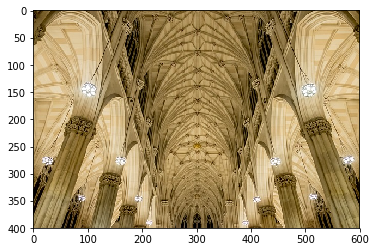

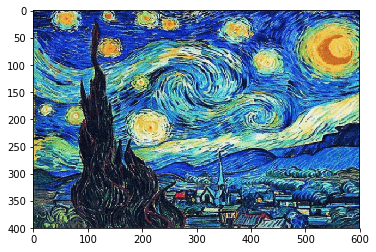

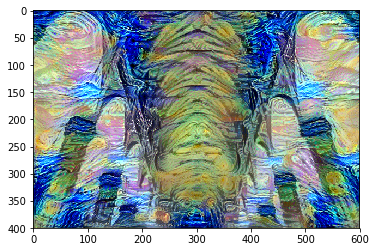

In [31]:
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(img)
plt.show()
